## Homework02: Three headed network in PyTorch

This notebook accompanies the [week02](https://github.com/girafe-ai/natural-language-processing/tree/master/week02_cnn_for_texts) practice session. Refer to that notebook for more comments.

All the preprocessing is the same as in the classwork. *Including the data leakage in the train test split (it's still for bonus points).*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
import tqdm
from collections import Counter

If you have already downloaded the data on the Seminar, simply run through the next cells. Otherwise uncomment the next cell (and comment the another one ;)

In [2]:
# uncomment and run this cell, if you don't have data locally yet.

!curl -L "https://www.dropbox.com/s/5msc5ix7ndyba10/Train_rev1.csv.tar.gz?dl=1" -o Train_rev1.csv.tar.gz
!tar -xvzf ./Train_rev1.csv.tar.gz

data = pd.read_csv("./Train_rev1.csv", index_col=None)

!wget https://raw.githubusercontent.com/pstrepetov/ml-mipt-course-advanced/main/assignment02_three_headed_network/network.py


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    17    0    17    0     0     33      0 --:--:-- --:--:-- --:--:--    33
100   342  100   342    0     0    364      0 --:--:-- --:--:-- --:--:--   364
100  119M  100  119M    0     0  35.9M      0  0:00:03  0:00:03 --:--:-- 71.1M
Train_rev1.csv
--2023-05-19 16:37:50--  https://raw.githubusercontent.com/pstrepetov/ml-mipt-course-advanced/main/assignment02_three_headed_network/network.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2284 (2.2K) [text/plain]
Saving to: ‘network.py’

network.py          100%[===================>]   2.23K  --.-KB/s    in 0s      

2023-05-19 16:37:50 (48.9 MB/s) - ‘

In [ ]:
# run this cell if you have downloaded the dataset on the seminar
#data = pd.read_csv("../../week02_CNN_n_Vanishing_gradient/Train_rev1.csv", index_col=None)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244768 entries, 0 to 244767
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Id                  244768 non-null  int64 
 1   Title               244767 non-null  object
 2   FullDescription     244768 non-null  object
 3   LocationRaw         244768 non-null  object
 4   LocationNormalized  244768 non-null  object
 5   ContractType        65442 non-null   object
 6   ContractTime        180863 non-null  object
 7   Company             212338 non-null  object
 8   Category            244768 non-null  object
 9   SalaryRaw           244768 non-null  object
 10  SalaryNormalized    244768 non-null  int64 
 11  SourceName          244767 non-null  object
dtypes: int64(2), object(10)
memory usage: 22.4+ MB


In [5]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

data.sample(3)


data_for_autotest = data[-5000:]
data = data[:-5000]

In [6]:
tokenizer = nltk.tokenize.WordPunctTokenizer()
# see task above
def normalize(text):
    text = str(text).lower()
    return ' '.join(tokenizer.tokenize(text))
    
data[text_columns] = data[text_columns].applymap(normalize)

print("Tokenized:")
print(data["FullDescription"][2::100000])
assert data["FullDescription"][2][:50] == 'mathematical modeller / simulation analyst / opera'
assert data["Title"][54321] == 'international digital account manager ( german )'

# Count how many times does each token occur in both "Title" and "FullDescription" in total
# build a dictionary { token -> it's count }
from collections import Counter
from tqdm import tqdm as tqdm

token_counts = Counter()# <YOUR CODE HERE>
for _, row in tqdm(data[text_columns].iterrows()):
    for string in row:
        token_counts.update(string.split())

# hint: you may or may not want to use collections.Counter

<ipython-input-6-aa034871b1a0>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[text_columns] = data[text_columns].applymap(normalize)


Tokenized:
2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object


239768it [00:24, 9906.34it/s] 


In [7]:
token_counts.most_common(1)[0][1]

2598827

In [8]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2500000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [token for token, count in token_counts.items() if count >= min_count]# <YOUR CODE HERE>
# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + sorted(tokens)
print("Vocabulary size:", len(tokens))

assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

token_to_id = {token: idx for idx, token in enumerate(tokens)}
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Total unique tokens : 201127
('and', 2598827)
('.', 2471477)
(',', 2266256)
('the', 2036428)
('to', 1977039)
...
('dbms_stats', 1)
('dbms_output', 1)
('dbms_job', 1)
Correct!
Vocabulary size: 33795
Correct!
Correct!


In [9]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [10]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[10705 29830  2143     1     1]
 [14875  2817     1     1     1]
 [27345 10107    15 15069 10702]]


In [11]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

<ipython-input-11-aadf0ebfcbad>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")


DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

### The deep learning part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.


#### Here comes the simple one-headed network from the seminar. 

In [12]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  191814
Validation size =  47954


In [13]:
def make_batch(data, max_len=None, word_dropout=0):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [14]:
a = make_batch(data_train[:3], max_len=10)

But to start with let's build the simple model using only the part of the data. Let's create the baseline solution using only the description part (so it should definetely fit into the Sequential model).

In [15]:
import torch
from torch import nn
import torch.nn.functional as F

In [16]:
# You will need these to make it simple

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class Reorder(nn.Module):
    def forward(self, input):
        return input.permute((0, 2, 1))

To generate minibatches we will use simple pyton generator.

In [17]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            target = batch.pop(target_column)
            yield batch, target
        
        if not cycle: break

In [18]:
iterator = iterate_minibatches(data_train, 3)
batch, target = next(iterator)

In [19]:
# Here is some startup code:
n_tokens=len(tokens)
n_cat_features=len(categorical_vectorizer.vocabulary_)
hid_size=64
simple_model = nn.Sequential()

simple_model.add_module('emb', nn.Embedding(num_embeddings=n_tokens, embedding_dim=hid_size))
simple_model.add_module('reorder', Reorder())
simple_model.add_module('conv1', nn.Conv1d(
    in_channels=hid_size,
    out_channels=hid_size,
    kernel_size=2)
                       )
simple_model.add_module('relu1', nn.ReLU())
simple_model.add_module('adapt_avg_pool', nn.AdaptiveAvgPool1d(output_size=1))
simple_model.add_module('flatten1', Flatten())
simple_model.add_module('linear1', nn.Linear(in_features=hid_size, out_features=1))
# <YOUR CODE HERE>

In [20]:
batch

{'Title': array([[27345,  6698,  6739,  5538, 27445, 10702,   195, 29543, 17009],
        [30080, 18670,  5458, 18664,  8796,     1,     1,     1,     1],
        [23865, 30073, 15402,  7676,     1,     1,     1,     1,     1]],
       dtype=int32),
 'FullDescription': array([[20386,  6347, 16289, ...,     1,     1,     1],
        [30411,  6835,   891, ...,  3682, 29406,   167],
        [27892, 10230,  2545, ...,     1,     1,     1]], dtype=int32),
 'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)}

__Remember!__ We are working with regression problem and predicting only one number.

In [21]:
# Try this to check your model. `torch.long` tensors are required for nn.Embedding layers.
simple_model(torch.tensor(batch['FullDescription'], dtype=torch.long))

tensor([[ 0.0935],
        [-0.0391],
        [ 0.0667]], grad_fn=<AddmmBackward0>)

In [22]:
batch['FullDescription'].shape

(3, 388)

And now simple training pipeline (it's commented because we've already done that in class. No need to do it again).

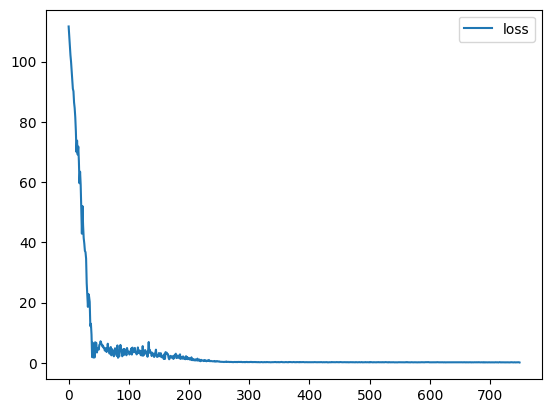

In [ ]:
# from IPython.display import clear_output
# from random import sample

# epochs = 1

# model = simple_model
# opt = torch.optim.Adam(model.parameters())
# loss_func = nn.MSELoss()

# history = []
# for epoch_num in range(epochs):
#     for idx, (batch, target) in enumerate(iterate_minibatches(data_train)):
#         # Preprocessing the batch data and target
#         batch = torch.tensor(batch['FullDescription'], dtype=torch.long)

#         target = torch.tensor(target)


#         predictions = model(batch)
#         predictions = predictions.view(predictions.size(0))

#         loss = loss_func(predictions, target)# <YOUR CODE HERE>

#         # train with backprop
#         loss.backward()
#         opt.step()
#         opt.zero_grad()
#         # <YOUR CODE HERE>

#         history.append(loss.data.numpy())
#         if (idx+1)%10==0:
#             clear_output(True)
#             plt.plot(history,label='loss')
#             plt.legend()
#             plt.show()

### Actual homework starts here
__Your ultimate task is to code the three headed network described on the picture below.__ 
To make it closer to the real world, please store the network code in file `network.py` in this directory. 

#### Architecture

Our main model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

<img src="https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png" width=600px>

This clearly doesn't fit into PyTorch __Sequential__ interface. To build such a network, one will have to use [__PyTorch nn.Module API__](https://pytorch.org/docs/stable/nn.html#torch.nn.Module).

In [23]:
import network

In [24]:
# Re-run this cell if you updated the file with network source code
import imp
imp.reload(network)

<module 'network' from '/content/network.py'>

In [25]:
hid_size = 64

model = network.ThreeInputsNet(
    n_tokens=len(tokens),
    n_cat_features=len(categorical_vectorizer.vocabulary_),

    # this parameter defines the number of the inputs in the layer,
    # which stands after the concatenation. In should be found out by you.
    concat_number_of_features=hid_size*2 + 20
)

In [26]:
testing_batch, _ = next(iterate_minibatches(data_train, 3))
testing_batch = [
    torch.tensor(testing_batch['Title'], dtype=torch.long),
    torch.tensor(testing_batch['FullDescription'], dtype=torch.long),
    torch.tensor(testing_batch['Categorical'])
]

In [27]:
assert model(testing_batch).shape == torch.Size([3, 1])
assert model(testing_batch).dtype == torch.float32
print('Seems fine!')

Seems fine!


Now train the network for a while (100 batches would be fine).

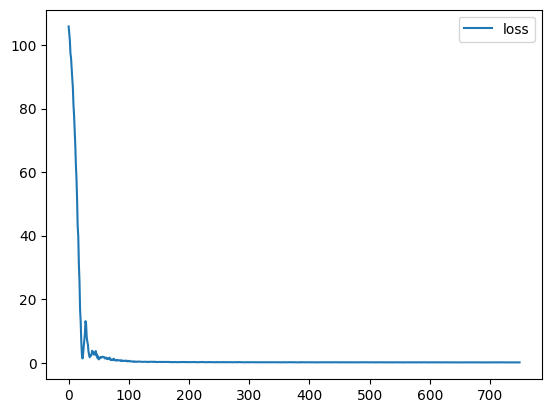

In [28]:
from IPython.display import clear_output
from random import sample

epochs = 1

opt = torch.optim.Adam(model.parameters())
loss_func = nn.MSELoss()

history = []
for epoch_num in range(epochs):
    for idx, (batch, target) in enumerate(iterate_minibatches(data_train)):
        # Preprocessing the batch data and target
        batch = [
            torch.tensor(batch['Title'], dtype=torch.long),
            torch.tensor(batch['FullDescription'], dtype=torch.long),
            torch.tensor(batch['Categorical'])
            ]

        target = torch.tensor(target)

        predictions = model(batch)
        predictions = predictions.view(predictions.size(0))

        loss = loss_func(predictions, target)

        # train with backprop
        loss.backward()
        opt.step()
        opt.zero_grad()

        history.append(loss.data.numpy())
        if (idx+1)%10==0:
            clear_output(True)
            plt.plot(history,label='loss')
            plt.legend()
            plt.show()

Now, to evaluate the model it can be switched to `eval` state.

In [29]:
model.eval()

ThreeInputsNet(
  (title_emb): Embedding(33795, 64)
  (title_encoder): Sequential(
    (0): Conv1d(64, 64, kernel_size=(2,), stride=(1,))
    (1): ReLU()
    (2): AdaptiveAvgPool1d(output_size=1)
    (3): Flatten()
  )
  (full_emb): Embedding(33795, 64)
  (full_encoder): Sequential(
    (0): Conv1d(64, 64, kernel_size=(2,), stride=(1,))
    (1): ReLU()
    (2): AdaptiveAvgPool1d(output_size=1)
    (3): Flatten()
  )
  (category_out): Sequential(
    (0): Linear(in_features=3746, out_features=600, bias=True)
    (1): ReLU()
    (2): Linear(in_features=600, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=20, bias=True)
  )
  (inter_dense): Linear(in_features=148, out_features=128, bias=True)
  (final_dense): Linear(in_features=128, out_features=1, bias=True)
)

In [30]:
def generate_submission(model, data, batch_size=256, name="", three_inputs_mode=True, **kw):
    squared_error = abs_error = num_samples = 0.0
    output_list = []
    for batch_x, batch_y in tqdm(iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw)):
        if three_inputs_mode:
            batch = [
                torch.tensor(batch_x['Title'], dtype=torch.long),
                torch.tensor(batch_x['FullDescription'], dtype=torch.long),
                torch.tensor(batch_x['Categorical'])
            ]
        else:
            batch = torch.tensor(batch_x['FullDescription'], dtype=torch.long)

        batch_pred = model(batch)[:, 0].detach().numpy()
        
        output_list.append((list(batch_pred), list(batch_y)))
        
        squared_error += np.sum(np.square(batch_pred - batch_y))
        abs_error += np.sum(np.abs(batch_pred - batch_y))
        num_samples += len(batch_y)
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % (squared_error / num_samples))
    print("Mean absolute error: %.5f" % (abs_error / num_samples))
    

    batch_pred = [c for x in output_list for c in x[0]]
    batch_y = [c for x in output_list for c in x[1]]
    output_df = pd.DataFrame(list(zip(batch_pred, batch_y)), columns=['batch_pred', 'batch_y'])
    output_df.to_csv('submission.csv', index=False)


In [31]:
generate_submission(model, data_for_autotest, name='Submission')
print('Submission file generated')

20it [00:05,  3.36it/s]

Submission results:
Mean square error: 0.15125
Mean absolute error: 0.30467
Submission file generated


__Both the notebook and the `.py` file are required to submit this homework.__